# Using custom TensorRT plugins with models defined in ONNX – Shown with the example of an Upsample layer

This notebook shows how to deploy custom layer plugins with DNN models represented in ONNX while using TensorRT as the back-end. The plugin interface allows users to add their own implementation of a (possibly exotic) layer to TensorRT's layer library. 

In the following, we will use an off-the-shelf AlexNet pre-trained with PyTorch, and replace its classification head with a simple nearest-neighbor Upsample layer. While the Upsample layer originally is not implemented in TensorRT 4.0, it has been added as a CUDA-based custom plugin inside this repository, which we are going to harness in this notebook.

Before we start, let's take a look at the output of `nvidia-smi` – especially pay attention to the memory utilization on the underlying GPU(s):

In [ ]:
!nvidia-smi

## 1. Adding an Upsample layer to AlexNet with PyTorch
First, we will import some helper libraries, together with the PyTorch modules we will make use of later for creating and validating our AlexNet with an Upsample head:

In [4]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from torch import nn
from torch.nn import functional as F

Now we can define our upsampling version of AlexNet. For that, we only take the feature extractor of an optionally pre-trained AlexNet, and add the `F.upsample` function on the feature extractor's output to the pipeline:

In [5]:
class AlexNet_upsample(nn.Module):
    def __init__(self, upsampling_factor=2, pretrained=True):
        """ 
        AlexNet without classification head, with an Upsample layer appended.
        The last layer before upsampling is a pooling layer of 256 feature maps.
        Example: 
        1x3x224x224 input ==> 
        1x256x6x6 output before upsampling ==>
        1x256x12x12 after upsampling with upsampling_factor=2.
        
        Parameters:
        
        upsampling_factor - The factor by which the final AlexNet feature maps are upsampled using the 
            nearest-neighbor approximation method.
        pretrained - Toggles whether a pre-trained network snapshot of AlexNet is used for initialization.
        """
        super(AlexNet_upsample, self).__init__()
        from torchvision.models import alexnet
        self.features = alexnet(pretrained=pretrained).features
        self.upsampling_factor = upsampling_factor
        
    def forward(self, x):
        x = self.features(x)
        x = F.upsample(x, size=None, scale_factor=self.upsampling_factor, mode='nearest', align_corners=None)
        return x

Let's now initialize an object with above class definition – it may take a while to download the weights of AlexNet pre-trained on ImageNet (only done once) ...

In [7]:
model_pytorch = AlexNet_upsample(upsampling_factor=2, pretrained=True)

... and then we load and transform an input image to feed it into our upsampling AlexNet later. Before copying it to GPU memory in the next step, we also convert it to a NumPy `ndarray` so that we can verify the correctness of our ONNX network topology later:

Data shape after loading the image from disk (in HWC order): (300, 300, 3)
Data shape after PyTorch pre-processing (in CHW order): torch.Size([3, 224, 224])
Data shape after adding a dimension for batch size (in NCHW order): torch.Size([1, 3, 224, 224])


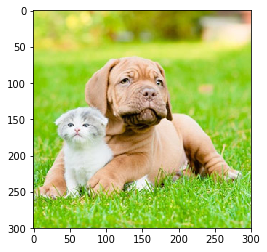

In [6]:
from torchvision import transforms

resolution=(224, 224)
preprocessing = transforms.Compose([transforms.Resize(resolution), transforms.ToTensor()])

def load_image_pytorch(path, resolution=(224, 224), normalize=True, verbose=False):
    image_raw = Image.open(INPUT_IMAGE_PATH)
    if verbose:
        plt.imshow(image_raw)
    if verbose:
        print('Data shape after loading the image from disk (in HWC order): %s' % str(np.array(image_raw).shape))
    data_pytorch = preprocessing(image_raw).float()
    if verbose:
        print('Data shape after PyTorch pre-processing (in CHW order): %s' % str(data_pytorch.shape))
    data_pytorch = data_pytorch.unsqueeze(0)
    if verbose:
        print('Data shape after adding a dimension for batch size (in NCHW order): %s' % str(data_pytorch.shape))
    return data_pytorch
    

INPUT_IMAGE_PATH = '/usr/src/tensorrt/data/ssd/dog.ppm'
input_data_pytorch = load_image_pytorch(INPUT_IMAGE_PATH, verbose=True)
input_data_numpy = input_data_pytorch.numpy()

We can later verify that the output from PyTorch matches the output from TensorRT. We hence perform a single forward-pass on the input data using PyTorch with the following, after converting both the AlexNet model and the previously loaded input data to CUDA mode (i.e., copying the weights and inputs to GPU memory):

In [8]:
model_pytorch = model_pytorch.cuda()
input_data_pytorch = input_data_pytorch.cuda()
output_data_pytorch = model_pytorch(input_data_pytorch)

## 2. Serializing the PyTorch model to disk with ONNX

We (hopefully) saw that PyTorch successfully performed a forward-pass of the upsampling AlexNet. In the following, we will first import the ONNX extension of the PyTorch framework and then export the network topology including its weights to the file path below. In the console output, triggered with the verbose parameter, we can verify that the Upsample head actually scales the last feature layer's spatial dimensions by the predefined factor.


In [9]:
import torch.onnx
ONNX_FILE_PATH = 'alexnet_upsample.onnx'

input_names = [ 'input' ] + [ 'learned_%d' % i for i in range(10) ]
output_names = [ 'upsampled' ]
torch.onnx.export(model_pytorch, input_data_pytorch, ONNX_FILE_PATH, 
                  verbose=True, input_names=input_names, output_names=output_names)

graph(%input : Float(1, 3, 224, 224)
      %learned_0 : Float(64, 3, 11, 11)
      %learned_1 : Float(64)
      %learned_2 : Float(192, 64, 5, 5)
      %learned_3 : Float(192)
      %learned_4 : Float(384, 192, 3, 3)
      %learned_5 : Float(384)
      %learned_6 : Float(256, 384, 3, 3)
      %learned_7 : Float(256)
      %learned_8 : Float(256, 256, 3, 3)
      %learned_9 : Float(256)) {
  %11 : Float(1, 64, 55, 55) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[11, 11], pads=[2, 2, 2, 2], strides=[4, 4]](%input, %learned_0, %learned_1), scope: AlexNet_upsample/Sequential[features]/Conv2d[0]
  %12 : Float(1, 64, 55, 55) = onnx::Relu(%11), scope: AlexNet_upsample/Sequential[features]/ReLU[1]
  %13 : Float(1, 64, 27, 27) = onnx::MaxPool[kernel_shape=[3, 3], pads=[0, 0, 0, 0], strides=[2, 2]](%12), scope: AlexNet_upsample/Sequential[features]/MaxPool2d[2]
  %14 : Float(1, 192, 27, 27) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[5, 5], pads=[2, 2, 2, 2], strides=[1, 1]](%

What's the impact to our GPU memory footprint after we switched to CUDA mode earlier? Compare the following output of `nvidia-smi` to the one on top of the notebook.

In [ ]:
!nvidia-smi

## 3. Adding a custom plugin for nearest-neighbor resizing to TensorRT and using it as an Upsample layer

At the time of writing this, TensorRT 4's library of natively supported layers does not include the nearest-neighbor Upsample layer we appended to our AlexNet without classification head.

Nearest-neighbor upsampling can be implemented as a simple scatter operation on the input data fed into the Upsample layer: Depending on the upsampling ratio that feed in as a parameter (`scale_factor` in PyTorch), an input pixel is written to several locations on a previously initialized output image plane. Sounds like a fantastic application for parallel processing using CUDA on the GPU!

Others have already done the job of implementing a nearest-neighbor Resizing kernel and adding it to TensorRT's library of user-defined plugins for you – nearest-neighbor upsampling is a subset of resizing with nearest-neighbor resampling. Now let's take a look at the steps required to do so.

### 3.1 Implementing a plugin for nearest-neighbor resizing: `ResizeNearest.hpp` and `ResizeNearest.cu`

First of all, we added the header file `ResizeNearest.hpp` to the directory `onnx_tensorrt/custom_plugins`. If you are interested in its contents, take a look at `onnx_tensorrt/custom_plugins/ResizeNearest.hpp`. Here we have defined the scaffolding of the class `ResizeNearestPlugin` that inherits from `onnx2trt::Plugin`. 

With `onnx_tensorrt/custom_plugins/ResizeNearest.cu`, we will add the implementation details: As previously mentioned, we have to initialize the dimensions of our output image plane when the Upsample layer is set up. We define `ResizeNearestPlugin::initialize()` for that purpose, which calls `ResizeNearestPlugin::getOutputDimensions()`. While you are invited to inspect the entire file `ResizeNearest.cu`, we will only point out the CUDA kernel for resizing the input, as shown below. This CUDA kernel is called during `int ResizeNearestPlugin::enqueue()`, the method responsible for a forward pass at runtime:

```c++
template <typename Data>
__global__
void resize_nearest_kernel_2d(int nbatch,
                              float2 scale,
                              int2 osize,
                              Data const* idata, int istride, int ibatchstride,
                              Data*       odata, int ostride, int obatchstride) {
  int x0 = threadIdx.x + blockIdx.x * blockDim.x;
  int y0 = threadIdx.y + blockIdx.y * blockDim.y;
  int z0 = blockIdx.z;
  for( int batch=z0; batch<nbatch; batch+=gridDim.z ) {
    for( int oy=y0; oy<osize.y; oy+=blockDim.y*gridDim.y ) {
      for( int ox=x0; ox<osize.x; ox+=blockDim.x*gridDim.x ) {
        int ix = int(ox / scale.x);
        int iy = int(oy / scale.y);
        odata[batch * obatchstride + oy * ostride + ox] =
          idata[batch * ibatchstride + iy * istride + ix];
      }
    }
  }
}
```

### 3.2 Enabling compilation of the `ResizeNearest` plugin: `CMakeLists.txt`

The file `ResizeNearest.cu`, containing the implementation of a nearest-neighbor resizing layer, should be taken into account by our compiler. Using a CMake compilation workflow, we can add it to the file `onnx-tensorrt/CMakeLists.txt`:

```
${PLUGIN_SOURCE_DIR}/ResizeNearest.cu
```
Here, `PLUGIN_SOURCE_DIR` points to the directory with sample plugins for TensorRT, `onnx-tensorrt/custom_plugins`.

### 3.3 Registering the `ResizeNearest` plugin to TensorRT's layer library: `builtin_plugins.cpp`

Even though we have enabled compilation of the `ResizeNearest` plugin in the previous step, it is still required to explicitly add it to TensorRT's library for custom layer plugins. Correspondingly, we need to first include the header files of the `ResizeNearest` plugin into `onnx-tensorrt/builtin_plugins.cpp`...
```c++
#include "custom_plugins/ResizeNearest.hpp"
```
... and then register it to said plugin library:
```c++
REGISTER_BUILTIN_PLUGIN("ResizeNearest",         ResizeNearestPlugin);
```

### 3.4 Using `ResizeNearest` for parsing ONNX layers of type `'Upsample'`: `builtin_op_importers.cpp`

Thanks to the previous step, we can add nearest-neighbor resizing layers to our model by using `ResizeNearest` plugins. So far so good, but how to integrate them into the parsing stage of TensorRT when we are reading in an ONNX file? And how can we configure `ResizeNearest` plugins to perform the `Upsample` operation of our example? 

These questions lead us to `onnx-tensorrt/builtin_op_importers.cpp`. This file is responsible for establishing the relationship of ONNX operators (or layers) identified during TensorRT's parsing stage to actual layer implementations with all parameters. It includes `onnx_helpers.hpp`, which again includes the list of operators part of the official ONNX definition. In case you are interested in how the `Upsample` operator is defined on a top level, you can take a look at __[onnx/defs/tensor/defs.cc](https://github.com/onnx/onnx/blob/master/onnx/defs/tensor/defs.cc)__.

Now back to integrating the custom `Upsample` plugin to the ONNX parsing stage of TensorRT. First of all, we include the headers of `ResizeNearest` on top of `onnx-tensorrt/builtin_op_importers.cpp`:
```c++
#include "custom_plugins/ResizeNearest.hpp"
```
The code inside `onnx-tensorrt/builtin_op_importers.cpp` realizes the magical interface between ONNX and TensorRT, as you can see skimming through the file. With the `DEFINE_BUILTIN_OP_IMPORTER` macro, TensorRT layer implementations of relatively simple ONNX operators such as `Add` or `Constant` are defined, as well as more complex ones with a variety of parameters such as `Conv`. 

That's what we will do to the target operator named `Upsample`. Look at the code snippet below: 

```c++
DEFINE_BUILTIN_OP_IMPORTER(Upsample) {
  ASSERT(inputs.at(0).is_tensor(), ErrorCode::kUNSUPPORTED_NODE);
  nvinfer1::ITensor& tensor = inputs.at(0).tensor();
  ASSERT(tensor.getDimensions().nbDims == 3, ErrorCode::kUNSUPPORTED_NODE);
  OnnxAttrs attrs(node);
  float height_scale, width_scale;
  if( !attrs.count("scales") ) {
    height_scale = attrs.get<float>("height_scale");
    width_scale  = attrs.get<float>("width_scale");
  } else {
    auto scales = attrs.get<std::vector<float>>("scales");
    ASSERT(scales.size() == 4, ErrorCode::kUNSUPPORTED_NODE);
    ASSERT(scales[0] == 1 && scales[1] == 1, ErrorCode::kUNSUPPORTED_NODE);
    height_scale = scales[2];
    width_scale  = scales[3];
  }
  auto scale = {height_scale, width_scale};
  auto mode = attrs.get<std::string>("mode", "nearest");
  ASSERT(mode == "nearest", ErrorCode::kUNSUPPORTED_NODE);
  RETURN_FIRST_OUTPUT(ctx->addPlugin(new ResizeNearestPlugin(scale),
                                     {&inputs.at(0).tensor()}));
}
```
After asserting that the input to the layer is a tensor of three dimensions (channels, height and width – batch size is handled implicitly), we can begin with parsing the operator's parameters. As we remember from the PyTorch definition of the Upsample layer, it used `F.upsample` with the parameters `upsampling_factor` and `mode`. If you'd like to dig deeper into the PyTorch code of __[torch/nn/functional.py](https://pytorch.org/docs/stable/_modules/torch/nn/functional.html#upsample)__ code, you would learn that `F.upsample` with the parameter `mode='nearest'` makes use of the function `torch._C._nn.upsample_nearest2d()` during inference, to which the parameter `upsampling_factor` is passed.

On the other hand, when we export our PyTorch model to ONNX, the conversions to the ONNX operator definitions are performed. As implemented in __[torch/onnx/symbolic.py](https://github.com/pytorch/pytorch/blob/master/torch/onnx/symbolic.py)__, `upsample_nearest2d()` translates the PyTorch parameter `scale_factor` to the ONNX parameters `width_scale_f` and `height_scale_f` (the `_f` appendix indicates a `float` data type), and the PyTorch parameter `mode_s=nearest` is fixed: 
```python
def upsample_nearest2d(g, input, scale_factor):
    return g.op("Upsample", input, width_scale_f=scale_factor,
                height_scale_f=scale_factor, mode_s="nearest")
```
With this context, the parameter parsing step in the C++ code snippet above almost explains itself.

Eventually, we add the `ResizeNearest` plugin to our graph definition in TensorRT by passing `scale` to its constructor and voilà: We have successfully enabled ONNX operators of type `Upsample` to be used with TensorRT, as long as they fulfill specific requirements such as having nearest-neighbor mode!

## 4. Using the custom `Upsample` plugin during inference after parsing the ONNX model from disk

Having generated the ONNX representation of an upsampling AlexNet and also having understood how the `Upsample` layer has been added to TensorRT's ONNX parser, we can finally perform inference with TensorRT. In this example, we make use of the ONNX Python front-end that makes use of the TensorRT back-end.

First of all, we will import the `onnx` package, and also `backend` from the Python package `onnx_tensorrt` that we have compiled from the files in this repository. We additionally import `pycuda.autoinit` to make sure our GPU(s) can be addressed properly when loading the model.

In [11]:
import onnx
import onnx_tensorrt.backend as backend
import pycuda.autoinit

Let's now load the ONNX file from disk store it in memory as `model_onnx`:

In [12]:
model_onnx = onnx.load(ONNX_FILE_PATH)

After that, the time for parsing `model_onnx` and building our TensorRT engine has come. The `onnx_tensorrt` package wraps this stage into the `prepare()` function to which we pass the result from parsing(`model_onnx`), the maximum batch size, the maximum workspace size in Bytes, and also the GPU index we'd like to infer on:

In [13]:
engine_tensorrt = backend.prepare(model_onnx, 
                                  max_batch_size=1,
                                  max_workspace_size=1<<28, # 256 MB
                                  device='CUDA:0')

Using the TensorRT engine, let's perform a single forward pass by ingesting the same input data as previously used for a with PyTorch and store the result in `output_data_tensorrt_numpy` (the output is a NumPy `ndarray`):

In [14]:
output_data_tensorrt_numpy = engine_tensorrt.run(input_data_numpy)[0]

And at last, the final sanity check of PyTorch and TensorRT. First, we will have to copy the contents of the PyTorch tensor `output_data_pytorch` from GPU to CPU memory, and then convert it to a NumPy `ndarray`, too. Then we are ready to compare the PyTorch and TensorRT outputs element by element. Due to e.g. the non-associative property of floating point calculation, it is unlikely to exactly achieve the same results for both frameworks:

In [15]:
output_data_pytorch_numpy = output_data_pytorch.data.cpu().numpy()
print('The maximum absolute difference between PyTorch and ONNX output is %.2E.' 
      % np.max(np.abs(output_data_tensorrt_numpy - output_data_pytorch_numpy)))

The maximum absolute difference between PyTorch and ONNX output is 5.72E-06.


You can expect a maximum absolute difference within the domain between 1E-6 and 1E-5. At last, let's also visualize the outputs:

In [68]:
def show_feature_maps(data_numpy, batch_idx=0, elements=4):
    """ Plots the first N elements of batch with batch_idx from data_numpy. """
    N,C,H,W = data_numpy.shape
    columns = 4
    rows = np.ceil(elements/columns).astype(np.int)
    fig = plt.figure(figsize=(8, 8))
    for i in range(elements):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(data_numpy[batch_idx][i])
    plt.show()

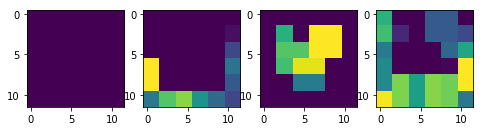

In [66]:
show_feature_maps(output_data_pytorch_numpy)

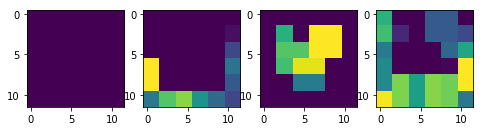

In [67]:
show_feature_maps(output_data_tensorrt_numpy)